In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/11/07 16:36
# @Author  : Wang Yujia
# @File    : PT_gen_oneforall.ipynb
# @Description : calculating U&P with inferred param

# 0. What for
1. 用infer的结果来算U和P
2. 使用的params是unique parameter
3. 设置threshold = K = 300
    - T < 300的padding（补零）
    - T > 300的求和到最后一个值

# 1. Preparations
## 1.1 全局设置

In [9]:
# 人工数据集or真实数据集
ARTIFICIAL = False
SHIFT = True
SHIFT_STR = "sft_bidfee"
# seed = [3,31,204,223,407]
seed = 512
noise_pct = 0.05
GT_w_Params = 2  # GT2 or GT3. If GT1, this will be ignored

# Small dataset
settings_small_NN_path = r"../../data/small_settings_NN.csv"
# Large data
settings_large_NN_path = r'E:\DATA\large_dta\large_settings_NN.csv'

# inferred params
if ARTIFICIAL:
    params_opitim_path =  r"../../data/SA_PT/params_artificial_GT"+str(GT_w_Params)+"_noise=" + str(noise_pct) + "_seed=" + str(seed) + ".csv"
else:
    # params_opitim_path = "../../data/SA_PT/params_seed="+str(seed)+".csv"
    params_opitim_path = "../../data/SA_PT/params_GT"+str(GT_w_Params)+"_seed=" + str(seed) + ".csv"

if SHIFT:
    params_opitim_path = "../../data/SA_PT/params_GT"+str(GT_w_Params)+"_"+SHIFT_STR+".csv"

# # output path
# if self.ARTIFICIAL:
#     self.params_gen_path = os.path.join(self.data_root, "data/SA_PT/params_artificial_GT"+str(self.GT_w_Params)+"_noise=" + str(self.noise_pct) + "_seed=" + str(self.seed) + ".csv")
# else:

# params_opitim_path = r"../../data/params_and_K_sampled.csv"
unique_setting_NN = ['desc','bidincrement','bidfee','retail','flg_endprice']
LEN = 300

# output path
if ARTIFICIAL:
    filename_P = r"../../data/SA_PT/results/GT_2_artificial_SA_LEN=" +str(LEN) +"_noise="+str(noise_pct)+"_seed="+str(seed)+ ".csv"
else:
    filename_P = r"../../data/SA_PT/results/GT_2_NN_LEN=300_seed="+str(seed)+ ".csv"

if SHIFT:
    filename_P = "../../data/SA_PT/results/GT_2_NN_LEN=300_"+SHIFT_STR+".csv"

import numpy as np
import csv
import os
import pandas as pd
from visdom import Visdom
from SA_for_PT_funcs_delta_eq1 import *
from tqdm import tqdm
import json

## 1.2 data 读取
1. data_key不变
2. 并且提取成功infer的参数结果`params_all`

In [10]:
params_opitim_path

'../../data/SA_PT/params_GT2_sft_bidinc.csv'

In [11]:

data_key_small = pd.read_csv(settings_small_NN_path, encoding="utf-8")
data_key_large = pd.read_csv(settings_large_NN_path, encoding="utf-8")
data_key = pd.concat([data_key_small,data_key_large],axis=0,ignore_index=True)

params_all = pd.read_csv(params_opitim_path, encoding="utf-8")


# 有`N_uniq_auction`组setting
LEN_small = data_key_small.shape[0]
LEN_large = data_key_large.shape[0]

# 2. U & P
## 2.1 generate

1. 对不同的auction settings做generate
2. generate过程: u-->p，然后把P存到dict里
3. U 由 `f_equi`得到
4. 注意P最后删去了第一个值P[0]，因此现在P[i]表示duration=i+1的概率

In [12]:
# col_names = ['bidincrement','bidfee','retail']
col_names = []
tmp = np.arange(0,LEN)
tmp_str = [str(x) for x in tmp]
col_names.extend(tmp_str)

P_df = pd.DataFrame(columns=col_names)

P_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299


In [13]:
# solve for U & P
for i in tqdm(range(LEN_small+LEN_large)):

    # Get params
    v = float(data_key.iloc[i,3])
    d = float(data_key.iloc[i,1])
    b = float(data_key.iloc[i,2])
    params = params_all.iloc[i,:]

    # if ARTIFICIAL:
    alpha = params[0].item()
    labda = params[1].item()
    # else:
    #     alpha = params[1].item()
    #     labda = params[3].item()

    # d==0 suggests a fixed-price auction
    if d == 0:
        T = np.inf                                    # duration limitation
    else:
        T = np.floor((v-b)/d)                         # duration limitation

    if T >= LEN:
        U = get_U_GT2(LEN,v, d, b, alpha, labda,eps = 0.)
    elif T < LEN:
        U = [0] * (LEN + 2)              # the prob. that someone offers a bid in t_th round
        U[0],U[1] = 1,1
        for t in range(2,len(U)):
            if(t <= T):  # 不超过理论上限T_i，可计算
                U[t] = f_Equi(t, v, d, b, alpha, labda)
            else:
                U[t] = 0
            assert U[t]>=0, "U[t]<0! when t ={},and b = {},v = {}, d = {}".format(t,b,v,d)
            assert U[t]<=1, "U[t]>1! when t ={},and b = {},v = {}, d = {}".format(t,b,v,d)

    # Solve for P with length of LEN
    P = get_P(U,LEN)
    # P[i][t] = U[i][1]*U[i][2]*...*(1-U[i][t+1])
    assert len(P)==LEN,"P has wrong length (should be LEN)"

    # 归一化这里不做的话，在输入NN之前也会在collate里面执行
    # if np.floor((v-b)/d) > LEN:
    #     scale_sum = np.sum(P)
    # P = P/np.sum(P)

    # Concat with dataframe
    pd_tmp = pd.DataFrame(P).T
    pd_tmp.columns = col_names
    P_df = pd.concat([P_df,pd_tmp],ignore_index=True)
    # # Plot
    # if(plot_flag& (i%10 == 0)):
    #     viz.line(p,np.arange(0,p.shape[0]),win = 'P_'+str(i),env=env_str, opts= dict(title = f'P_{i}_v={v}_b={b}_d={d}'))
print("Done")


100%|██████████| 1276/1276 [00:03<00:00, 323.86it/s]

Done


# 3. save

In [14]:
filename_P

'../../data/SA_PT/GT_2_NN_LEN=300_sft_bidinc.csv'

In [15]:
P_df.to_csv(filename_P,header=True,index=False,encoding="utf-8")
print("DONE")

DONE


(array([2., 1., 4., 2., 2., 0., 1., 2., 1., 2., 0., 1., 1., 0., 2., 0., 2.,
        4., 0., 1., 0., 3., 0., 0., 2., 2., 1., 3., 0., 0., 2., 0., 0., 4.,
        0., 2., 1., 0., 1., 0., 1., 0., 2., 0., 3., 1., 1., 1., 0., 5., 2.,
        1., 2., 0., 1., 2., 0., 1., 1., 0., 0., 0., 0., 1., 0., 3., 1., 2.,
        2., 1., 1., 0., 0., 2., 1., 0., 0., 0., 0., 3., 2., 0., 0., 2., 2.,
        0., 1., 1., 0., 0., 1., 0., 1., 2., 0., 0., 1., 1., 0., 2., 0., 0.,
        0., 2., 4., 1., 1., 0., 1., 0., 1., 0., 2., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 3.]),
 array([  2.        ,   4.11382114,   6.22764228,   8.34146341,
         10.45528455,  12.56910569,  14.68292683,  16.79674797,
         18.91056911,  21.02439024,  23.13821138,  25.25203252,
         27.36585366,  29.4796748 ,  31.59349593,  33.70731707,
         35.82113821,  37.93495935,  40.04878049,  42.16260163,
         44.27642276,  46.3902439 ,  48.50406504,  50.61788618,
         52.73170732,  54.84552846,  56.95934959,  59.0731

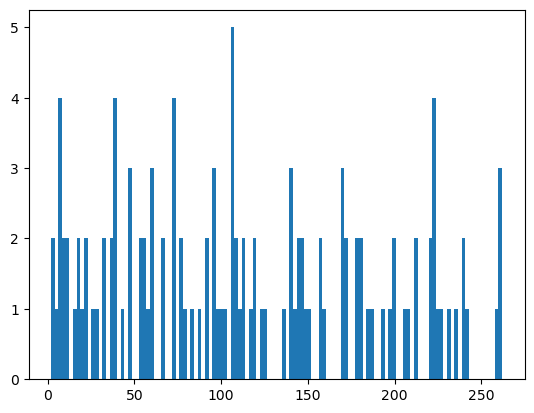

In [12]:
import matplotlib.pyplot as plt

plt.figure()
ax = plt.subplot(111)
# padding zero hist: 太多padding with zero会影响效果
ax.hist(zero_padding_len,bins=len(zero_padding_len))

# 4. 读取json并且还原viz环境

In [11]:

viz_path = "../data/vis/P.json"
with open(viz_path,"r") as f:
    pre_data=json.load(f)

tmp = pre_data['jsons'].values()
for i in range(0,len((pre_data['jsons']).keys())):
    tmpi = list(tmp)[i]
    viz.line(
        X=np.array(tmpi['content']["data"][0]["x"]),
        Y=np.array(tmpi['content']["data"][0]["y"]),
        env = "P_oneforall",
        win = tmpi['id'],
        opts= dict(title=tmpi['title']),
    )